# Ejemplo del satélite artificial: Aplicación del método RK4, y monitorización del error

<ul id="top">
<li><a href="#1-Implementación-del-método-de-Runge-Kutta-de-orden-4-(RK4)">1-Implementación del método de Runge-Kutta de orden 4 (RK4)</a></li>
<li><a href="#2-Comprobación-de-RK4-en-el-ejemplo-del-robot-móvil">2-Comprobación de RK4 en el ejemplo del robot móvil</a></li>
<li><a href="#3-Satélite-artificial-orbitando-alrededor-de-la-tierra:-Modelo-simplificado">3-Satélite artificial  orbitando alrededor de la tierra: Modelo simplificado</a></li>
<li><a href="#4-Satélite-artificial-orbitando-alrededor-de-la-tierra:-Modelo-más-realista">4-Satélite artificial  orbitando alrededor de la tierra: Modelo más realista</a></li>
<li><a href="#Valoración">Valoración</a></li>
</ul>  

In [1]:
using LinearAlgebra
using Plots
using DelimitedFiles

## 1-Implementación del método de Runge-Kutta de orden 4 (RK4)

Queremos simular numéricamente la evolución de sistemas modelados por 
ecuaciones diferenciales ordinarias (EDOs) de dimensión $d\geq 1$ de la forma

<a id='Edo-Compacta'></a>
\begin{equation*}
\frac{d}{dt} u = f(t,u,p). \hspace{10em} \tag{1}
\end{equation*}

donde $u =(u^1,\ldots,u^d) \in \mathbb{R}^d$ es el _vector de estado_ del sistema, y $p \in \mathbb{R}^m$ es un vector de parámetros constantes del sistema.

Sabemos que, fijado el vector $p$ de parámetros constantes, 
dados $t_0 \in \mathbb{R}$ y $u_0 =(u^1_0,\ldots,u^d_0) \in \mathbb{R}^d$, existe una única solución $u(t)$ de [(1)](#Edo-Compacta) que satisfaga la condición inicial

<a id='Cond-Ini'></a>
\begin{equation*}
  u(t_0)=u_0. \hspace{12em} \tag{2}
\end{equation*}

En la práctica, nos interesará calcular de forma aproximada la solución $u(t)$ para un cierto intervalo temporal $t \in [t_0,T]$. Se aproximará dicha solución en una discretización del tiempo obtenida de dividir el intervalo temporal $[t_0,T]$ en $n$ partes iguales. Es decir,  se tomará los valores discretos del tiempo $t_0,t_1,t_2,\ldots,t_{n-1},t_n=T$, donde $t_k=t_{0}+k h$, con $h=(T-t_0)/n$, y se calcularán las aproximaciones 
$u_k =(u^1_k,\ldots,u^d_k) \approx u(t_k)$ para $k=0,1,\ldots,n$.


Para realizar los ejercicios de simulación que siguen, se debe primeramente implementar el método RK4 (en julia, R, o python). Se definirá una función (que llamaremos RK4) que toma como argumentos de entrada $u0, t0, T, n, f, p, m$.

El significado de los primeros seis argumentos de entrada de dicha función se puede deducir de las consideraciones de arriba. Como argumento de entrada adicional, se considerará un entero positivo $m$ cuyo significado se explicará a continuación, y cuyo valor por defecto será $m=1$. (Es decir, si cuando se invoca a la función RK4, se dan como argumentos de entrada $u0, t0, T, n, f, p$, se considerará que $m=1$.

Si $m=1$, ello indicará que para cada $j=1,\ldots,n$, se obtendrá la aproximación $u_j \approx u(t_j)$ aplicando un paso de longitud $h=(T-t_0)/n$ del método RK4. En cambio, si $m>1$, cada aproximación $u_j \approx u(t_j)$ se obtendrá aplicando $m$ pasos de longitud $h=(T-t_0)/(n m)$ del método RK4. Esto último será conveniente si sólo queremos los resultados para $n+1$ tiempos, pero la aproximación obtenida con el método de RK4 con $h=(T-t_0)/n$ no es suficientemente precisa.



El argumento de entrada $f$ es el nombre de una función previamente definida, tal que dados $t \in \mathbb{R}$, un vector $u \in \mathbb{R}^d$, y un vector de parámetros $p\in \mathbb{R}^m$,
devuelve un vector $f(t,u,p) \in \mathbb{R}^d$. Dicha función determina un sistema de EDOs de la forma [(1)](#Edo-Compacta).

La función RK4 debe devolver como argumento de salida una matriz $W \in \mathbb{R}^{(n+1) \times (d+1)}$

\begin{eqnarray*}
W = \left(
     \begin{array}{cccc}
t_0    &   u^1_0 & \cdots& u^d_0  \\
t_1    &    u^1_1 & \cdots& u^d_1  \\
\vdots &  \vdots & \vdots& \vdots \\
t_{n}  &      u^1_n & \cdots& u^d_n
     \end{array}
\right),
\end{eqnarray*} 

donde $t_k = t_0 + k \, h$, $h=(T-t_0)/n$, y los vectores $u_k  = (u^1_k,\ldots,u^d_k) \in \mathbb{R}^d$ ($k=1\ldots,n$) son aproximaciones de $u(t_k)$ que se han obtenido aplicando el método RK4 al sistema  [(1)](#Edo-Compacta) con la condición inicial  [(2)](#Cond-Ini) (con longitud de paso $h=(T-t_0)/(n m)$). 


In [2]:
"""
Metodo de Runge-Kutta de orden 4
"""
function  RK4(u0, t0, T, n, f, p, m=1)
    h = (T-t0)/(n*m);   # Calculo de la longitud de paso
    # Se deduce la dimension del sistema de EDOs a partir del numero 
    # de componentes del vector de estado inicial
      d = length(u0)  
    # Inicializacion a cero de la matriz de salida de resultados
      W = zeros(n+1,d+1)
      W[1,:] = [t0; u0]  # Se rellena la primera fila de la matriz de resultados 
      tj = t0
      uj = u0
    # Calculo sucesivo de los tiempos tj y las aproximaciones uj de u(tj)
    for j in 1:n
        for i in 1:m
        k1 = f(tj, uj, p)
        uuj = uj + h/2*k1 
        k2 = f(tj+h/2, uuj, p)
        uuj = uj + h/2*k2
        k3 = f(tj+h/2, uuj, p)
        uuj = uj + h*k3
        k4 = f(tj+h, uuj, p)
        uj = uj + h/6 * (k1 + 2*k2 + 2*k3 + k4)
        tj = tj + h
        end
        W[j+1,:] = [tj; uj] # Se introduce el resultado del paso j-ésimo 
                            # en la fila (j+1)-ésima de la matriz de resultados
    end
    return W
  end

RK4

<a href="#top">Back to the top</a>

## 2-Comprobación de RK4 en el ejemplo del robot móvil

### 2.1- Ejercicio

Una vez implementada la función RK4,
 - **Resolver numéricamente (con el método de RK4) el sistema correspondiente al robot móvil considerado en la entrega de la 3ª semana, para obtener los valores de $u(t)=(x(t),y(t),\theta(t))$ para los tiempos $t = 0, 10, 20, \ldots,1000$. Representar gráficamente la evolución de $x(t)$, $y(t)$, y $\theta(t)$.**

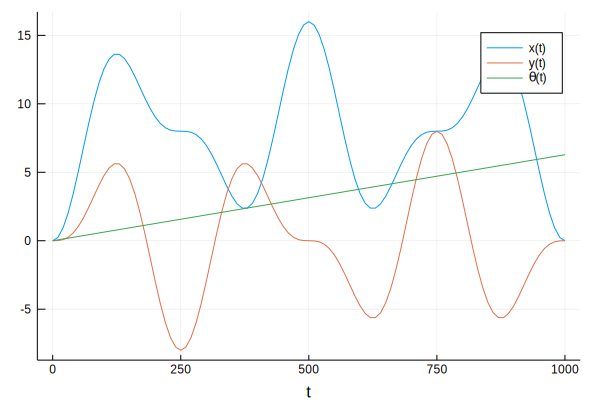

In [3]:
function fRobot(t,u,p)
    L = p[1]
    R = p[2]
    x = u[1]
    y = u[2]      
    theta = u[3]
    vl = (3/5*sin(pi/125*t) - 1/200)
    vr = (3/5*sin(pi/125*t) + 1/200)
    dx =  pi*R*(vl+vr)*cos(theta)
    dy =  pi*R*(vl+vr)*sin(theta)
    dtheta = 2*pi*R*(vr-vl)/L       
    return [dx,dy,dtheta]
end


L = 0.5
R = 0.05
p = [L,R]
u0 = [0.,0.,0.]

T = 1000
n=100
h=T/n

res = RK4(u0,0.,T,n,fRobot,p);

tt = res[:,1]
xx = res[:,2]
yy = res[:,3]
thetas = res[:,4]
plot(tt,[xx, yy,thetas], xlabel="t",label=["x(t)" "y(t)" "\\theta (t)"])

 - **Obtener tres aproximaciones distintas con las longitudes de paso $h=10$, $h=5$, y $h=2.5$ respectivamente, y calcular los errores cometidos en cada caso (tal como se hizo para el método de Euler mejorado en la entrega de la 3ª semana) y representarlos gráficamente en una misma figura.**

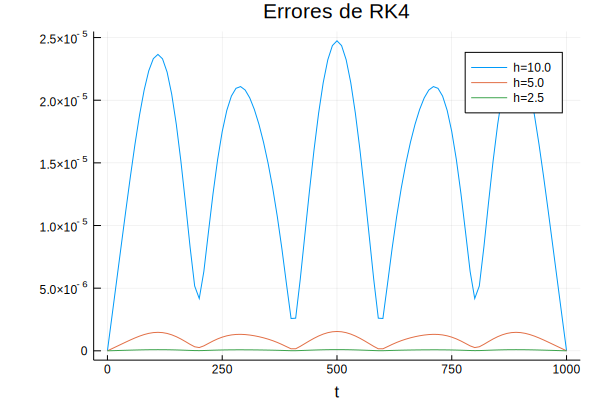

In [4]:
function RobotSol(t)
    theta = π*t/500
    c3 = cos(3*theta)
    s3 = sin(3*theta)
    c5 = cos(5*theta)
    s5 = sin(5*theta)
    x = 8 - 5 * c3 - 3 * c5
    y = 5 * s3 - 3 * s5
    return [x, y, theta]
end

function errorRK4(n,m)   
    L = 0.5
    R = 0.05
    p = [L,R]
    u0 = [0.,0.,0.]
    T = 1000
    res = RK4(u0,0.,T,n,fRobot,p,m)
    tt = res[:,1]
    errores = zeros(n+1)
    for j in 1:(n+1)
       errores[j] = norm(res[j,2:4]-RobotSol(tt[j]))
    end
    return (tt,errores)
end


n=100
hh = [T/100, T/200, T/400]

(tt, errores) = errorRK4(n,1)
plot(tt,errores,
     title="Errores de RK4",
     xlabel="t", label=string("h=",hh[1]))

(tt, errores2) = errorRK4(n,2)
plot!(tt,errores2, label=string("h=",hh[2]))

(tt, errores4) = errorRK4(n,4)
plot!(tt,errores4, label=string("h=",hh[3]))

 - **Obtener una figura con las tres gráficas de los errores divididos por $h^4$.**

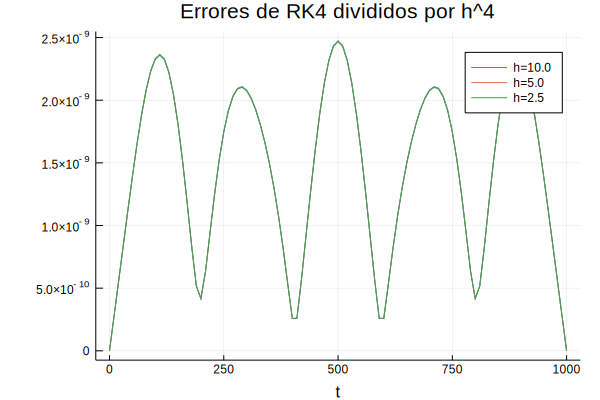

In [5]:
plot(tt,errores/hh[1]^4,
     title="Errores de RK4 divididos por h^4",
     xlabel="t",label=string("h=",hh[1]))

plot!(tt,errores2/hh[2]^4, label=string("h=",hh[2]))

plot!(tt,errores4/hh[3]^4, label=string("h=",hh[3]))

> **Comprobación**
>
>Las tres gráficas de los errores divididas por $h^4$ se deberían superponer aproximadamente (en caso de que no lo sean, señal de que se ha cometido algún fallo), lo que indicaría que los errores son aproximadamente proporcionales a $h^4$. Ello es de esperar, porque RK4 es un método de orden 4. 

<a href="#top">Back to the top</a>

## 3-Satélite artificial orbitando alrededor de la tierra: Modelo simplificado


Consideraremos la evolución de un satélite artificial moviéndose bajo el influjo gravitacional de la tierra. En el modelo matemático que consideramos seguídamente (propuesto en el siglo XVII por Isaac Newton), se supone para simplificar que la tierra es una esfera con campo gravitacional uniforme. Las unidades utilizadas son kilómetros para la distancia, y segundos para el tiempo.

Según dicho modelo, las coordenadas (respecto del centro de la tierra) $(x,y,z)$ del satélite obedecen el siguiente sistema de ecuaciones diferenciales de segundo orden:

\begin{align*}
\frac{d^2 x}{dt^2} &= -\frac{\mu}{(\sqrt{x^2+y^2+z^2})^3} x,\\ 
\frac{d^2 y}{dt^2} &= -\frac{\mu}{(\sqrt{x^2+y^2+z^2})^3} y,\\ 
\frac{d^2 z}{dt^2} &= -\frac{\mu}{(\sqrt{x^2+y^2+z^2})^3} z,
\end{align*}
    
donde  $\mu$ es la constante gravitacional del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra, tenemos que

\begin{equation*} 
    \mu = 398600.8\, Km^3/s^2.
\end{equation*}

Dicho sistema de EDOs de segundo orden se puede reescribir como un sistema de EDOs de primer orden añadiendo las variables de estado $(v_x,v_y,v_z)$ correspondientes a las tres componentes de la velocidad del satélite:

\begin{align*}
\frac{d}{dt} 
\left(
  \begin{matrix}
    x \\ y \\ z \\v_x \\ v_y\\ v_z
  \end{matrix}
\right)
&=
\left(
  \begin{matrix}
 v_x\\
 v_y\\
 v_z\\
 \displaystyle - \frac{\mu \, x}{(\sqrt{x^2+y^2+z^2})^3} ,\\ 
 \displaystyle - \frac{\mu \, y}{(\sqrt{x^2+y^2+z^2})^3},\\ 
\displaystyle -\frac{\mu \, z}{(\sqrt{x^2+y^2+z^2})^3},
  \end{matrix}
\right).
    \end{align*}


A lo largo del presente ejercicio, consideraremos las siguientes condiciones iniciales:

\begin{equation*}
  \begin{split}
 x(0)&=0,\  \qquad y(0)=37947.73745727695 \, Km,\  \qquad z(0)=0, \\ 
 v_x(0)&=3.297676220718193 \, Km/s, \quad v_y(0)=0, \quad v_z(0)=0.8244190551795483\,  Km/s.
  \end{split}
\end{equation*}

Para dichas condiciones iniciales, se obtiene una _órbita 
geosíncrona_, es decir, una órbita periódica de periodo igual al periodo de rotación de la tierra (23 horas, 56 minutos, y 4 segundos, es decir, un día sidéreo, ligéramente menor que la duración del día solar) que traducido a segundos totales es $T=86164\, s$.  


### 3.1- Ejercicio

- **Aplicar el método RK4 para calcular las coordenadas $(x_k,y_k,z_k)$ del satélite en los tiempos $t_k=k\, T/1000$, para $k=0,1,\ldots,1000$ ($T=86164\, s$).  Utilizar $h=T/(4n)=T/4000$ como longitud de paso del método RK4. Obtener una figura con la trayectoria en 3D del satélite alrededor de la tierra.** 

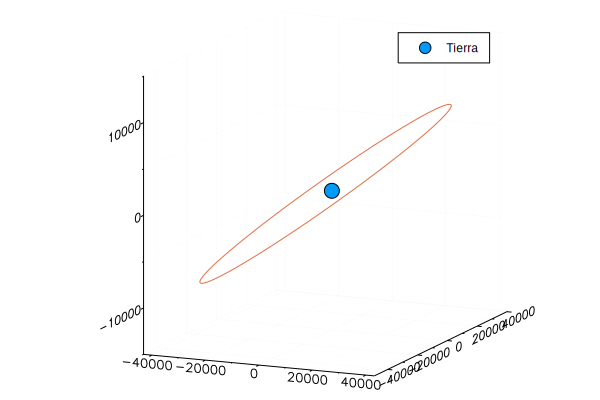

In [6]:
function fsat(t,u,μ)
    x = u[1]
    y = u[2]
    z = u[3]
    dx = u[4]
    dy = u[5]
    dz = u[6]
    r2 = x^2+y^2+z^2
    r = sqrt(r2)
    aux = -μ/(r*r2)
    return [dx, dy, dz, aux*x, aux*y, aux*z]
end

μ = 398600.8
u0 = [0., 37947.73745727695, 0., 3.297676220718193, 0., 0.8244190551795483]
T = 86164.
n = 1000
res = RK4(u0,0.,T,n,fsat,μ,4)

tt = res[:,1]
xx = res[:,2]
yy = res[:,3]
zz = res[:,4]
rr = sqrt.(xx.^2+yy.^2+zz.^2)


plot([0.],[0.],[0.],marker=8,label="Tierra")
plot!(xx,yy,zz, label="")

- **Guardar las coordenadas $(x_k,y_k,z_k)$ del satélite en los tiempos $t_k=k\, T/1000$, para $k=0,1,\ldots,1000$, en un fichero de texto, a tres columnas ($x$ en la primera columna, $y$ en la segunda, $z$ en la tercera). Utilizar el fichero obtenido para realizar una simulación animada del movimiento del satélite orbitando alrededor de la tierra, haciendo uso del codigo JavaScripts que se encuentra en este** <a href="http://www.ehu.eus/ccwmuura/irakaskuntza/sinum/animaciones/tierra_satelite_fichero.html">Fichero html</a>

In [7]:
writedlm("satelliteXYZ.txt",res[:,2:4]," ")

### 3.2-Ejercicio

- **Para aseguraros de que la aproximación numérica es suficientemente precisa, queremos  representar gráficamente la evolucion 
(para $k=1,2,\ldots,1000$) del error  en la posición del satélite**
<a id='Error-posicion'></a>
\begin{equation*}
\sqrt{(x_k -x(t_k))^2+(y_k -y(t_k))^2+(z_k -z(t_k))^2}. \tag{3}
\end{equation*}
**En la práctica, en lugar de tratar de calcular los errores de forma exacta,  calcularemos las estimaciones del error cometido por medio del procedimiento de estimación del error descrito al final de la exposición del Tema~2 (para ello, hay que tener en cuenta que RK4 es un método de orden 4). En el cálculo estimado de los errores en posición del satélite, se obtendrá sustituyendo en [(3)](#Error-posicion) los errores cometidos en cada componente de $(x_k,y_k,z_k)$ por la estimación del error correspondiente.**

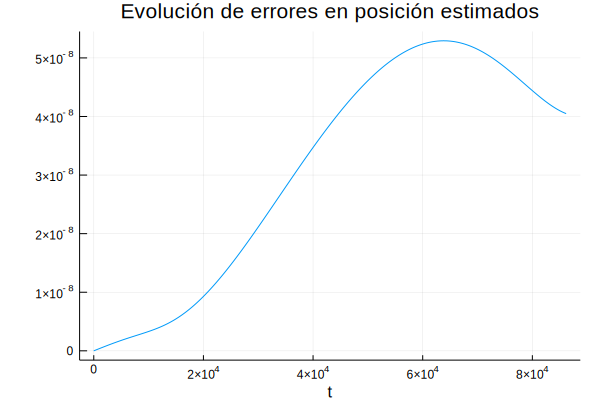

In [8]:
res2 = RK4(u0,0.,T,n,fsat,μ,2)
orden = 4
fac = 1/(2^orden-1)
errx = fac*(res2[:,2]-res[:,2])
erry = fac*(res2[:,3]-res[:,3])
errz = fac*(res2[:,4]-res[:,4])
errores = sqrt.(errx.^2 + erry.^2 + errz.^2)
tt = res[:,1]
plot(tt,errores,xlabel="t",label="",title="Evolución de errores en posición estimados")

### 3.3-Ejercicio

- **Se sabe que la solución exacta es periódica, con periodo $T$, de modo que tiene las mismas posiciones y velocidades en $t=0$ y $t=T$. Por tanto, el error en el tiempo final $t_n=T$ se puede calcular de forma exacta. Comparar dicho error exacto con la estimación obtenida en el apartado anterior para  el tiempo final $t_n=T$.**

In [9]:
errfinalx = res[end,2]-res[1,2]
errfinaly = res[end,3]-res[1,3]
errfinalz = res[end,4]-res[1,4]
errortiempofinal = sqrt(errfinalx^2 + errfinaly^2 + errfinalz^2)
(errortiempofinal,errores[end])

(4.003000646203863e-8, 4.0492520964663956e-8)

- **¿Es dicha estimación del error en $t=T$ de magnitud similar al error cometido realmente?**

>**Respuesta**
>
>Comparando el verdadero error en posiciones en el instante final con el error estimado en dicho instante, comprobamos que la estimación del error da una idea muy buena del error cometido realmente.

<a href="#top">Back to the top</a>

## 4-Satélite artificial orbitando alrededor de la tierra: Modelo más realista

En el apartado anterior, hemos supuesto que la tierra es esférica, cuando en realidad presenta un ligero achatamiendo en ambos polos.  En el modelo matemático que consideramos a continuación, se obtiene una descripción más realista del movimiento del satélite artificial teniendo en cuenta dicho achatamiento. (Sin embargo, no se tiene en cuenta otros efectos de índole menor, como  el efecto gravitacional de la luna, el sol, y otros cuerpos celestes, ni el efecto de irregularidades menores del campo gravitacional de la tierra).

Según este modelo matemático, las coordenadas respecto del centro de la tierra $(x,y,z)$ del satélite obedecen el siguiente sistema de ecuaciones diferenciales de segundo orden:

\begin{align*}
\frac{d^2 x}{dt^2} &= -\mu \frac{x}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right),\\ 
\frac{d^2 y}{dt^2} &= -\mu \frac{y}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right),\\ 
\frac{d^2 z}{dt^2} &= -\mu \frac{z}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, G \right),
\end{align*}

donde 
\begin{equation*}
r=\sqrt{x^2+y^2+z^2}, \quad
  F = \frac{3}{2} -  \frac{15z^2}{2r^2},  \quad G = \frac{9}{2} - \frac{15z^2}{2r^2},
\end{equation*}

y $\mu$, $R$, y $\epsilon$, respectivamente, son la constante gravitacional, el radio, y el coeficiente de achatamiento del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra, tenemos que

\begin{equation*} 
    \mu = 398600.8 Km^3/s^2, \quad R = 6\, 378.135Km,  \quad               
    \epsilon = 0.0010826157.
\end{equation*}

Como en el modelo simplificado considerado en el apartado anterior, este sistema de EDOs de segundo orden se puede reescribir como un sistema de EDOs de primer orden añadiendo las variables de estado $(v_x,v_y,v_z)$ correspondientes a las tres componentes de la velocidad del satélite.

### 4.1-Ejercicio

- **¿Cuales son las variables de estado?**
- **¿Cuales son los parámetros constantes del problema? **
- **¿Qué variables no son ni variables de estado ni parámetros constantes del problema? (Tales variables son variables auxiliares intermedias utilizadas para definir de forma conveniente las distinas componentes de la aceleración del satélite).**

>**Respuesta**
>
>- Las variables de estado son: $x, y, v, v_x, v_y, v_z$
>- Los parámetros constantes del problema son: $\mu, R, \epsilon$
>- Las variables $r, F, G$ _son variables auxiliares intermedias_

### 4.2-Ejercicio

A lo largo del presente ejercicio, consideraremos las mismas condiciones iniciales que en el apartado anterior. Queremos comprobar si, en el caso del modelo más realista, la trayectoria correspondiente sigue siendo periódica, con periodo $T$.


- **Aplicar el método RK4, utilizando $h=T/4000$ como longitud de paso, para calcular las posiciones y velocidades del satélite en los tiempos $t_k=k\, T/1000$, para $k=0,1,\ldots,1000$. Calcular la distancia entre las posiciones del satélite en $t=0$ y $t=T$.**

In [10]:
function fsat2(t,u,p)
    μ = p[1]
    R = p[2]
    ϵ = p[3]
    x = u[1]
    y = u[2]
    z = u[3]
    dx = u[4]
    dy = u[5]
    dz = u[6]
    r2 = x^2+y^2+z^2
    r = sqrt(r2)
    aux1 = -μ/(r*r2)
    F = 1.5 - 7.5*(z/r)^2
    G =  3 + F
    aux2 = ϵ*(R/r)^2
    aux3 = aux1*(1+aux2*F)
    aux4 = aux1*(1+aux2*G)
    return [dx, dy, dz, aux3*x, aux3*y, aux4*z]
end


μ = 398600.8
R = 6378.135
ϵ = 0.0010826157
p = [μ, R, ϵ]
u0 = [0., 37947.73745727695, 0., 3.297676220718193, 0., 0.8244190551795483]
T = 86164.
n = 1000
res = RK4(u0,0.,T,n,fsat2,p,4)
tt = res[:,1]
xx = res[:,2]
yy = res[:,3]
zz = res[:,4]
dist = sqrt((xx[end]-xx[1])^2 + (yy[end]-yy[1])^2 + (zz[end]-zz[1])^2)

23.269005340489667

### 4.3-Ejercicio

- Comprobaréis que dicha distancia no es cero. ** ¿Esto será debido al error inherente al método RK4 utilizado, o a que realmente la trayectoria del satélite en el nuevo modelo ya no es periódica con periodo $T$?**

>**Respuesta**
>
>_En principio, podría tratarse del error del método RK4, aunque también podría ser que la trayectoria en el nuevo modelo no sea periódica con periodo T._

### 4.4-Ejercicio

- **Para tratar de responder con más seguridad a la pregunta del punto 4.3, obtener una gráfica de la evolución de los errores de posición estimados, tal como se hizo en el apartado anterior.**

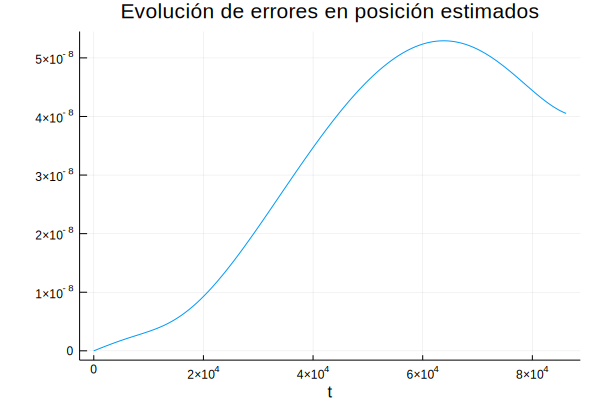

In [11]:
res2 = RK4(u0,0.,T,n,fsat2,p,2)
orden = 4
fac = 1/(2^orden-1)
errx = fac*(res2[:,2]-res[:,2])
erry = fac*(res2[:,3]-res[:,3])
errz = fac*(res2[:,4]-res[:,4])
errores = sqrt.(errx.^2 + erry.^2 + errz.^2)
tt = res[:,1]
plot(tt,errores,xlabel="t",label="",title="Evolución de errores en posición estimados")

### 4.5-Ejercicio

- ** En vista del tamaño del error estimado, responder de forma razonada si la trayectoria del satélite es periódica de periodo $T$ o no. **

>**Respuesta**
>
>Según la estimación del error obtenida, este error es menor que 1e-7 Km (0.1 mm). Por tanto, la diferencia de más de 23 Km entre las posiciones del satélite en t=0 y la calculada para t=T debe ser correcta, y no debida al error del método RK4. Por tanto, en el modelo realista, la trayectoria del satélite ya no es periódica de periodo T.

### 4.6-Ejercicio

- **Representar la proyección en el plano OXY (en el plano del ecuador) de la trayectoria del satélite en el intervalo $[0,T]$.**

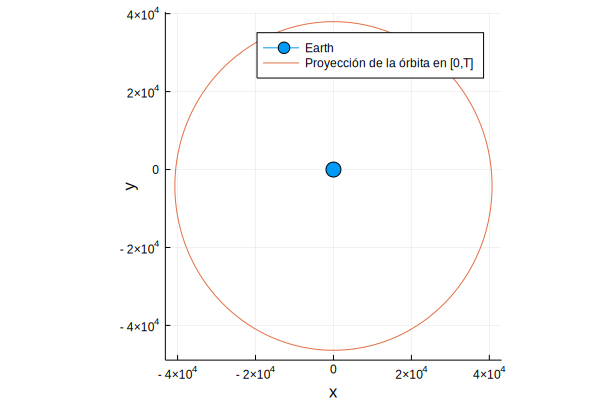

In [18]:
uf = res[end,2:7]

n = 1000
m = 4
res = RK4(u0,0.,T,n,fsat2,p,m)
tt = res[:,1]
xx = res[:,2]
yy = res[:,3]
zz = res[:,4]


plot([0.],[0.],marker=8,label="Earth")
plot!(xx,yy,xlabel="x", ylabel="y",label="Proyección de la órbita en [0,T]", aspect_ratio=1)

- **Aplicar el método RK4  con $h=T/4000$ como longitud de paso, para calcular la posición y velocidad del satélite en $t = 3660\, T$** (es decir, cuando ha transcurrido aproximadamente diez años).

In [17]:
res = RK4(u0,0.,3660T,1,fsat2,p,4000*3660)
uf = res[end,2:7]

6-element Array{Float64,1}:
  34446.80929589261     
 -22000.268482219773    
   1592.2779871419357   
     -1.3685705970217261
     -2.758758585005559 
     -0.7431495586890531

>**Comprobación**
>
> La posición y velocidad que obtiene para $t=3660T$ es
> $(x, y, z) = (34446.80929589261,-22000.268482219773,1592.2779871419357)$,
  $( v_x, v_y, v_z) = (-1.3685705970217261, -2.758758585005559, -0.7431495586890531)$

- **Representar la proyección en el plano del ecuador de la trayectoria del satélite en el intervalo $[3660\, T,3661\, T]$. Representarlo en una misma figura junto con la obtenida para el intervalo $[0,T]$, para comparar como cambia la órbita del satélite a lo largo de (aproximadamente) diez años.**

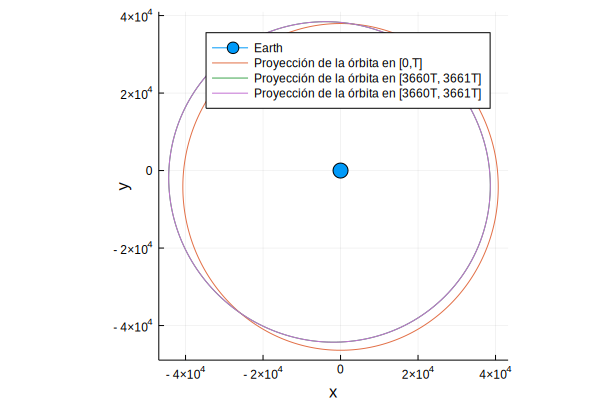

In [20]:
n = 1000
m = 4
res2 = RK4(uf,3666*T,3661*T,n,fsat2,p,m)
tt2 = res2[:,1]
xx2 = res2[:,2]
yy2 = res2[:,3]
zz2 = res2[:,4]

plot!(xx2,yy2,label="Proyección de la órbita en [3660T, 3661T]")

> **Comprobación**
>
> Se deberían obtener dos elipses (casi circulares) giradas una con respecto a la otra. A lo largo del tiempo, la elipse que forma la trayectoria del satélite va girando, un fenómeno que ocurre debido al achatamiento de la tierra en los polos, y que se llama precesión de la órbita.

<a href="#top">Back to the top</a>

### Valoración

_Incluir aquí los comentarios de valoración de la tarea a entregar (dificultad, interés, etc, incluidas, si se quiere, sugerencias de mejora del ejercicio), así como una estimación del tiempo dedicado al trabajo de la semana (desglosado en el tiempo de estudio de material teórico, tiempo de dedicación a la participación activa o pasiva en los foros, tiempo de implementación y experimentación con los problemas prácticos planteados, y tiempo de preparación del documento jupyter final)._